In [1]:
'''Example script showing how to use stateful RNNs
to model long sequences efficiently.
'''
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM


# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 20
# number of elements ahead that are used to make the prediction
lahead = 1

Using TensorFlow backend.


Generating Data...
Input shape: (5000, 1, 1)
Output shape: (5000, 1)
Creating Model...
Training
Epoch 0 / 20
Epoch 1/1
5000/5000 [==============================] - 4s - loss: 2769.1421       

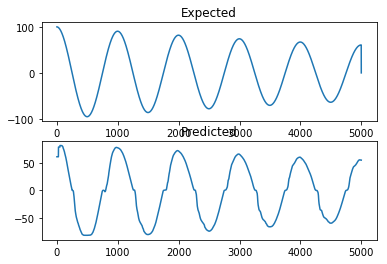

In [2]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=5000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing

    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos


print('Generating Data...')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape:', expected_output.shape)

print('Creating Model...')
model = Sequential()
model.add(LSTM(50,
               input_shape=(tsteps, 1),
               batch_size=batch_size,
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

print('Plotting Results')
plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()